**Objective:** This is an exploration of 3 unsupervised techniques used to detect anomalies, K-Means, LOF, and Isolation Forest. 
    
We will explore an ensemble approach that theorically will leverage the strengths of both clustering and local density-based anomaly detection. 

The caveat is these techniques are primarily for numerical variables. Techniques such as one hot encoding can be used to adapt categorical variables.

The dataset is on claims submitted by medical providers.

In [1]:
import os
import sys

import pandas as pd
import pandasql as ps
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest

user = os.environ.get("USER")
sys.path.append(f"/Users/{user}/utils/")

In [2]:
data_path = f"/Users/{user}/data/Provider_Anomaly_Dataset.csv"

### Load Dataset

In [3]:
df = pd.read_csv(data_path, low_memory=False)

In [4]:
df['Claims_Count'] = df['Claims_Count'].round(0)
df['Patient_Count'] = df['Patient_Count'].round(0)

In [5]:
df.head()

,Provider_ID,Claim_Amount,Claims_Count,Patient_Count,Average_Treatment_Cost
0,12595,2397.37,15.0,14.0,202.42
1,15440,1889.39,22.0,6.0,174.39
2,14389,2518.15,23.0,17.0,113.29
3,18290,3218.42,18.0,11.0,142.92
4,14631,1812.68,21.0,12.0,229.92


### Summary Statistics

In [6]:
df['Claim_Amount'].describe()

count     1000.000000
mean      2275.653093
std       2209.000456
min       -593.010000
25%       1501.752500
50%       2041.700000
75%       2549.787500
max      31731.721560
Name: Claim_Amount, dtype: float64

In [7]:
df['Claims_Count'].describe()

count    1000.000000
mean       21.201000
std        10.636905
min         7.000000
25%        17.000000
50%        20.000000
75%        23.000000
max       155.000000
Name: Claims_Count, dtype: float64

In [8]:
df['Patient_Count'].describe()

count    1000.00000
mean       14.82100
std         3.86418
min         4.00000
25%        12.00000
50%        15.00000
75%        17.00000
max        28.00000
Name: Patient_Count, dtype: float64

In [9]:
df['Average_Treatment_Cost'].describe()

count    1000.000000
mean      154.001801
std        70.954073
min         5.020000
25%       115.690000
50%       148.920000
75%       182.980000
max       849.888269
Name: Average_Treatment_Cost, dtype: float64

### k-means clustering

In [10]:
feature_cols = ['Claim_Amount', 'Claims_Count', 'Patient_Count', 'Average_Treatment_Cost']
df_scaled = StandardScaler().fit_transform(df[feature_cols])

In [11]:
kmeans = KMeans(n_clusters=5, random_state=42)
df['cluster'] = kmeans.fit_predict(df_scaled)

In [12]:
df.head()

,Provider_ID,Claim_Amount,Claims_Count,Patient_Count,Average_Treatment_Cost,cluster
0,12595,2397.37,15.0,14.0,202.42,0
1,15440,1889.39,22.0,6.0,174.39,0
2,14389,2518.15,23.0,17.0,113.29,1
3,18290,3218.42,18.0,11.0,142.92,0
4,14631,1812.68,21.0,12.0,229.92,0


In [13]:
df.cluster.value_counts(2)

0    0.358
1    0.350
4    0.272
3    0.014
2    0.006
Name: cluster, dtype: float64

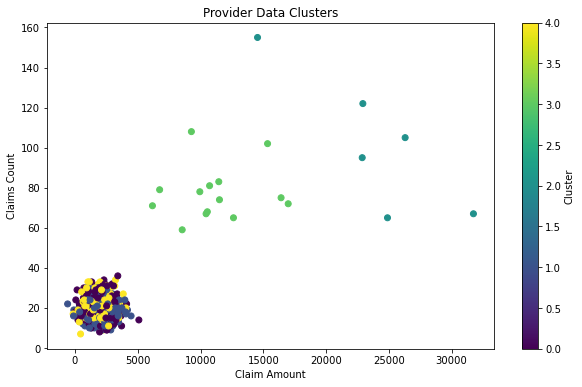

In [14]:
plt.figure(figsize=(10, 6))

plt.scatter(df['Claim_Amount'], df['Claims_Count'], c=df['cluster'], cmap='viridis')
plt.xlabel('Claim Amount')
plt.ylabel('Claims Count')
plt.title('Provider Data Clusters')
plt.colorbar(label='Cluster')
plt.show()

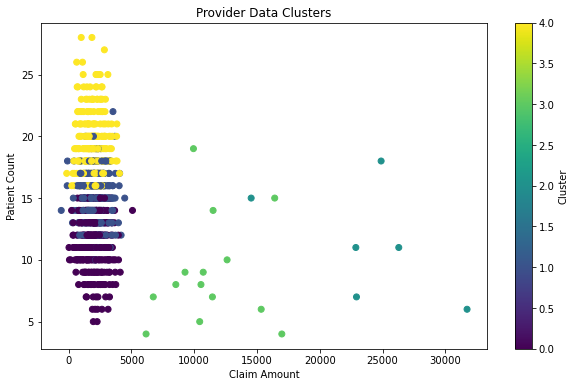

In [15]:
plt.figure(figsize=(10, 6))

plt.scatter(df['Claim_Amount'], df['Patient_Count'], c=df['cluster'], cmap='viridis')
plt.xlabel('Claim Amount')
plt.ylabel('Patient Count')
plt.title('Provider Data Clusters')
plt.colorbar(label='Cluster')
plt.show()

**Purple Cluster**: Low claim amount with varying patient counts

**Blue and Yellow Clusters**: Moderate claim amount with medium patient counts

**Green Clusters**: High claim amount with lower patient counts

**Takeaway**: The focus should be on green clusters. Providers that are far right on the plot (high claim amount) but down towards the bottom (low patient count) could be outliers or anomalies. This observation could be indicative of high-cost specialty providers or possibly providers whose suspicious billing practices.

Next, we will look at the providers that are outliers within their respective clusters.

### Local Outlier Factor

In [16]:
features_of_interest = df[['Claim_Amount', 'Claims_Count', 'Patient_Count', 'Average_Treatment_Cost']]

In [17]:
# Normalizing these features to set them to a same scale
scaler = StandardScaler()
norm_features = scaler.fit_transform(features_of_interest)

In [18]:
# Calculating LOF score
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
lof_scores = lof.fit_predict(norm_features)
lof_neg_scores = -lof.negative_outlier_factor_ 

In [19]:
df['LOF_Score'] = lof_neg_scores

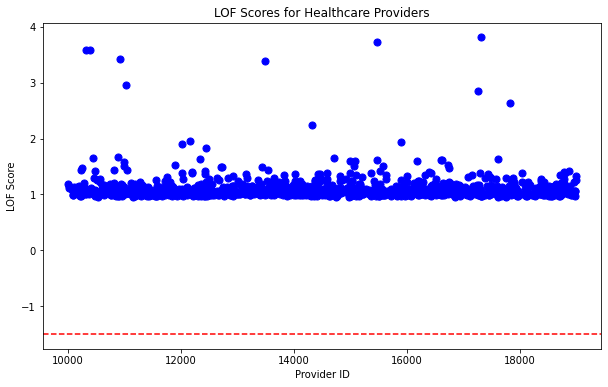

In [20]:
plt.figure(figsize=(10, 6))
plt.scatter(df['Provider_ID'], df['LOF_Score'], color='blue', s=50)
plt.axhline(y=-1.5, color='r', linestyle='--')
plt.xlabel('Provider ID')
plt.ylabel('LOF Score')
plt.title('LOF Scores for Healthcare Providers')
plt.grid(False)
plt.show()

### LOF within Each Cluster

In [21]:
df['LOF_Score'] = 0

In [22]:
for c in df['cluster'].unique():
    cluster_data = df[df['cluster'] == c][feature_cols]
    lof = LocalOutlierFactor(n_neighbors=5, contamination=0.05)
    df.loc[df['cluster'] == c, 'LOF_Score'] = lof.fit_predict(cluster_data)

In [23]:
# Identifying outliers
df['Outlier'] = df['LOF_Score'] <= -1

In [24]:
df[df['Outlier'] == True].head()

,Provider_ID,Claim_Amount,Claims_Count,Patient_Count,Average_Treatment_Cost,cluster,LOF_Score,Outlier
11,13813,1627.42,22.0,19.0,252.11,4,-1,True
30,13565,1518.63,18.0,14.0,259.25,0,-1,True
40,17541,2590.77,22.0,14.0,46.28,1,-1,True
48,17493,2274.89,19.0,23.0,89.17,4,-1,True
74,13177,-95.80,19.0,18.0,100.32,1,-1,True


In [25]:
df.Outlier.value_counts(2)

False    0.948
True     0.052
Name: Outlier, dtype: float64

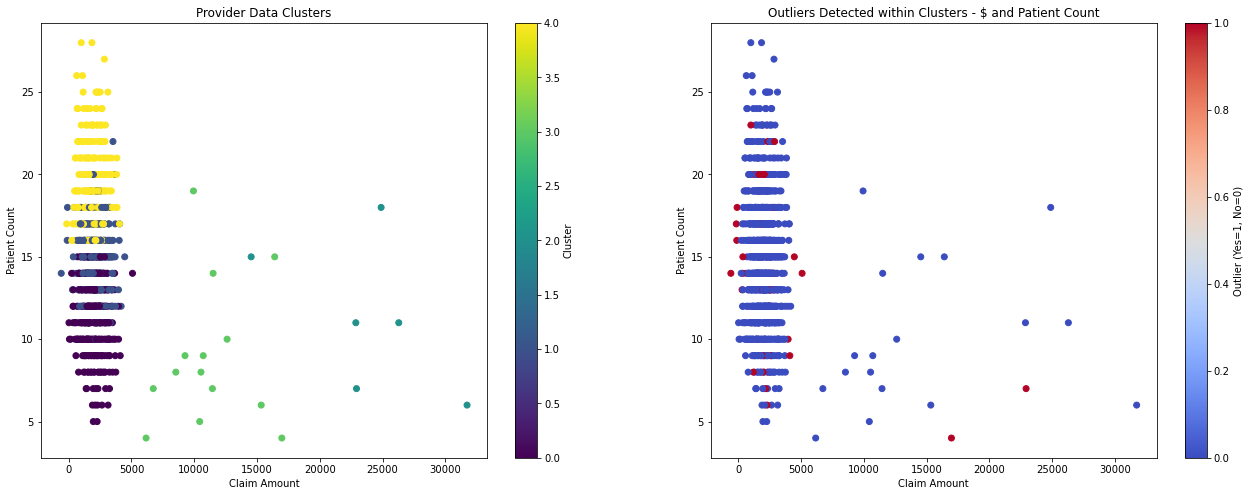

In [26]:
plt.figure(figsize=(22, 8))

plt.subplot(1, 2, 1)
scatter1 = plt.scatter(df['Claim_Amount'], df['Patient_Count'], c=df['cluster'], cmap='viridis')
plt.xlabel('Claim Amount')
plt.ylabel('Patient Count')
plt.title('Provider Data Clusters')
plt.colorbar(scatter1, label='Cluster')

plt.subplot(1, 2, 2)
scatter2 = plt.scatter(df['Claim_Amount'], df['Patient_Count'], c=df['Outlier'], cmap='coolwarm')
plt.xlabel('Claim Amount')
plt.ylabel('Patient Count')
plt.title('Outliers Detected within Clusters - $ and Patient Count')
plt.colorbar(scatter2, label='Outlier (Yes=1, No=0)')

plt.show()

Red indicates Outliers. We can observe that they are scattered throughout but are particularly noticeable in areas with either high claim amounts or very low patient counts

**Takeaway**: providers with high claim amounts and relatively fewer patients may require audits to verify the legitimacy of the claims filed.
    
Additional statistical analyses are needed on both the outliers and the dense clusters to understand the underlying causes of such distributions. We can look at data such as types of treatment provided, demographic information of patients, or geographical factors to get a deeper insights into why certain providers are outliers.

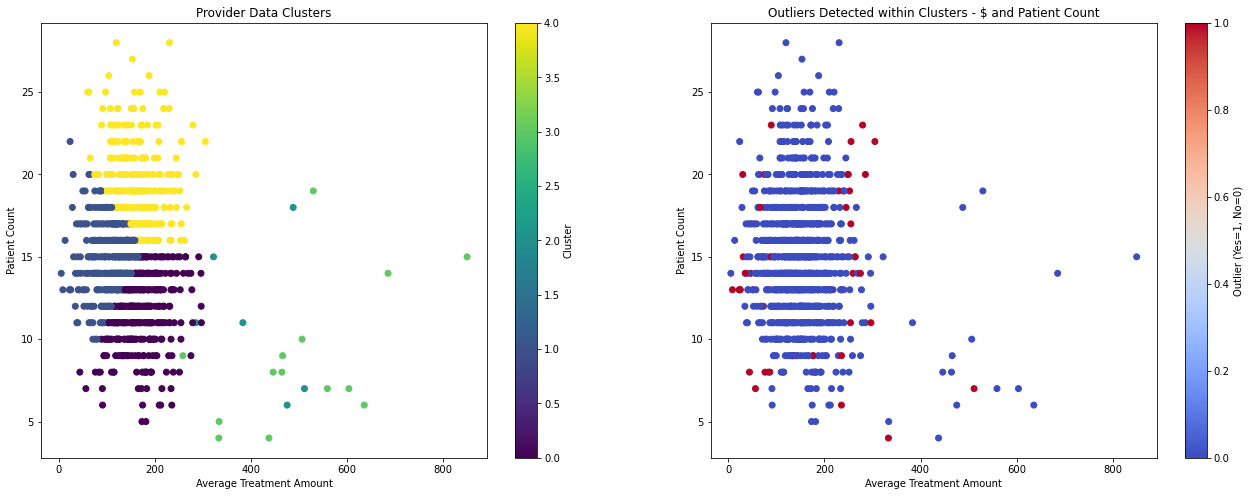

In [27]:
plt.figure(figsize=(22, 8))

plt.subplot(1, 2, 1)
scatter1 = plt.scatter(df['Average_Treatment_Cost'], df['Patient_Count'], c=df['cluster'], cmap='viridis')
plt.xlabel('Average Treatment Amount')
plt.ylabel('Patient Count')
plt.title('Provider Data Clusters')
plt.colorbar(scatter1, label='Cluster')

plt.subplot(1, 2, 2)
scatter2 = plt.scatter(df['Average_Treatment_Cost'], df['Patient_Count'], c=df['Outlier'], cmap='coolwarm')
plt.xlabel('Average Treatment Amount')
plt.ylabel('Patient Count')
plt.title('Outliers Detected within Clusters - $ and Patient Count')
plt.colorbar(scatter2, label='Outlier (Yes=1, No=0)')
plt.show()

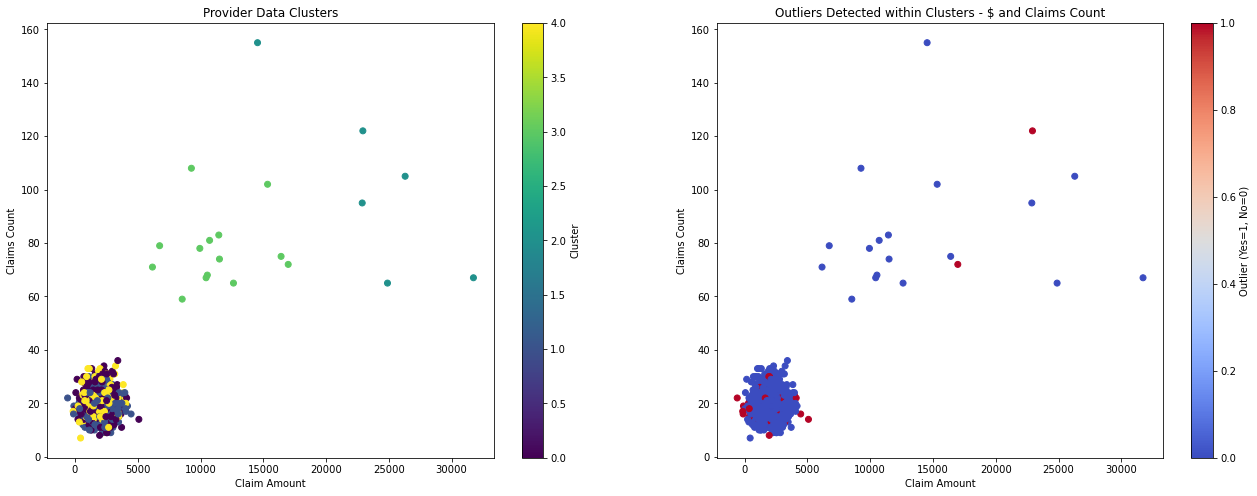

In [28]:
plt.figure(figsize=(22, 8))

plt.subplot(1, 2, 1)
scatter1 = plt.scatter(df['Claim_Amount'], df['Claims_Count'], c=df['cluster'], cmap='viridis')
plt.xlabel('Claim Amount')
plt.ylabel('Claims Count')
plt.title('Provider Data Clusters')
plt.colorbar(scatter1, label='Cluster')

plt.subplot(1, 2, 2)
scatter2 = plt.scatter(df['Claim_Amount'], df['Claims_Count'], c=df['Outlier'], cmap='coolwarm')
plt.xlabel('Claim Amount')
plt.ylabel('Claims Count')
plt.title('Outliers Detected within Clusters - $ and Claims Count')
plt.colorbar(scatter2, label='Outlier (Yes=1, No=0)')
plt.show()

### Isolation Forest

In [29]:
iso_forest = IsolationForest(n_estimators=500, random_state=42)

iso_forest.fit(features_of_interest)

labels = iso_forest.predict(features_of_interest) # Predicting the anomalies (-1 for outliers, 1 for inliers)

In [30]:
features_of_interest['anomaly'] = labels

outliers = features_of_interest[features_of_interest['anomaly'] == -1].copy()

print("Number of outliers detected:", len(outliers))

Number of outliers detected: 69


<ipython-input-30-071c7bf99979>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_of_interest['anomaly'] = labels


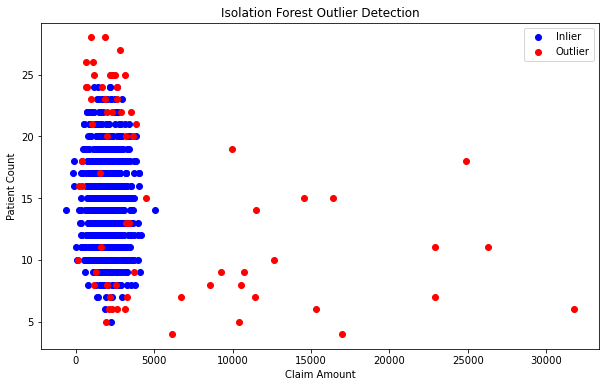

In [31]:
plt.figure(figsize=(10, 6))
plt.scatter(features_of_interest.loc[features_of_interest['anomaly'] == 1, 'Claim_Amount'
                                    ], features_of_interest.loc[features_of_interest['anomaly'] == 1, 'Patient_Count'
                                                               ], c='blue', label='Inlier')
plt.scatter(features_of_interest.loc[features_of_interest['anomaly'] == -1, 'Claim_Amount'
                                    ], features_of_interest.loc[features_of_interest['anomaly'] == -1, 'Patient_Count'
                                                               ], c='red', label='Outlier')
plt.xlabel('Claim Amount')
plt.ylabel('Patient Count')
plt.legend()
plt.title('Isolation Forest Outlier Detection')
plt.show()

### Conclusion

**K-Means Clustering:** clusters data into groups and evaluates outlier status based on deviation from these groups. Outliers were determined based on their distance from the cluster centroids. It tends to highlight outliers that are far from the cluster centers but may miss anomalies within dense clusters.
    
**Local Outlier Factor:** considers the local density deviation of a data point with respect to its neighbors. It is particularly sensitive to outliers in denser regions, highlighting anomalies that diverge in density from their immediate surroundings. This can make LOF more effective in identifying anomalies within clusters than k-means, which is generally more focused on centroid-based clustering.
    
**Isolation Forest:** provides a robust, general-purpose outlier detection mechanism. It focuses on isolating outliers by randomly selecting features and splitting the dataset. It is less influenced by the overall data structure (such as cluster formation or local density) and more on how 'separable' points are in the feature space. This can lead to broader identification of outliers across different regions of the data spread, including those within high-density areas and those in sparse regions.

### What does this mean in terms of Fraud detection strategy?

**IF for Broad Screening:** In the detection of fraudulent claims, IF can serve as a broad screening tool to quickly isolate cases that are clearly unusual or atypical, efficiently narrowing down the pool of claims for further investigation.

**LOF for Detailed Examination:** LOF, with its ability to scrutinize the local vicinity of each data point, is more suited for a detailed examination where high precision is required to identify fraud that blends in more closely with legitimate data. LOF would likely pinpoint fraudulent claims based on subtle inconsistencies or irregularities that differ from the norm observed among similar cases.

**KM for Pre-Processing Step:** can be used to segment the data into clusters before applying LOF or IF. This segmentation can help tailor anomaly detection strategies to different groups or types of data